In [47]:
import numpy as np
import pandas
from PyLMD import LMD
from pyemd import emd as EMD
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import LSTM
import os
import os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt

In [48]:
# load data
data_file_path = osp.join('data', 'walmart-sales-dataset-of-45stores.csv')
df = pandas.read_csv(data_file_path)
df.info()
df.head()
mx = df['Weekly_Sales'].max()
mn = df['Weekly_Sales'].min()
df['Weekly_Sales'] = df['Weekly_Sales'].apply(lambda x: (x - mn) / (mx - mn))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [49]:
# LMD decomposition
num_pf = 0
lmd = LMD()
df_stores = df.groupby('Store')
PFs_stores = []
res_stores = []
time_num = df_stores.get_group(1).shape[0]
store_num = df_stores.ngroups
for idx,df_store in df_stores:
    y = df_store['Weekly_Sales'].values
    PFs, res = lmd.lmd(y)
    PFs_stores.append(PFs)
    res_stores.append(res)
    num_pf = max(num_pf, len(PFs))

data_stores = []

for i in range(len(PFs_stores)):
    if len(PFs_stores[i]) < num_pf:
        PFs_stores[i] = np.pad(PFs_stores[i], ((0,num_pf-len(PFs_stores[i])),(0,0)), 'constant', constant_values=0)
    data_stores.append(df_stores.get_group(i+1))
    for j in range(num_pf):
        data_stores[-1].insert(len(data_stores[-1].columns), 'PF'+str(j), PFs_stores[i][j])
    data_stores[-1].insert(len(data_stores[-1].columns), 'Res', res_stores[i])
    
data_stores[0].head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,PF0,PF1,PF2,PF3,PF4,PF5,Res
0,1,05-02-2010,0.397291,0,42.31,2.572,211.096358,8.106,0.002314,0.025848,0.001778,0.006789,-0.009845,0.0,0.370406
1,1,12-02-2010,0.396811,1,38.51,2.548,211.242170,8.106,0.007927,0.019803,0.002174,0.006345,-0.009845,0.0,0.370406
2,1,19-02-2010,0.388501,0,39.93,2.514,211.289143,8.106,0.013509,0.006131,0.002550,0.005749,-0.009845,0.0,0.370406
3,1,26-02-2010,0.332458,0,46.63,2.561,211.319643,8.106,-0.031059,-0.004684,0.002651,0.004989,-0.009845,0.0,0.370406
4,1,05-03-2010,0.372661,0,46.50,2.625,211.350143,8.106,0.017316,-0.011414,0.002159,0.004039,-0.009845,0.0,0.370406


In [50]:
class Data:
    x = None
    y = None
    def __init__(self,x,y) -> None:
        self.x = x.astype(np.float64)
        self.y = y.astype(np.float64)
    
    def __str__(self) -> str:
        return 'x: ' + str(self.x) + ' y: ' + str(self.y)
    
class MyDataset(Dataset):
    data = None
    def __init__(self, data) -> None:
        self.data = data
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index):
        d = self.data[index]
        return torch.Tensor(d.x), torch.Tensor(d.y)

In [51]:
train_ratio = 0.8
train_sample = np.random.choice(len(data_stores), int(len(data_stores)*train_ratio), replace=False)
test_sample = np.array(list(set(range(len(data_stores))) - set(train_sample)))

q = 4 # window size = q+1, use q previous data to predict the next one

def get_window(data, i, q):
    return data[i-q:i+1]

def get_data(sample):
    data = []
    for i in sample:
        store = data_stores[i]
        values = store.values
        for j in range(q, len(store)):
            window = get_window(values, j, q)
            data.append(Data(window[:-1,3:], window[-1,2:3]))
    return data

train_data = get_data(train_sample)
test_data = get_data(test_sample)
test_one_data = get_data(test_sample[0:1])
# test_one_data = get_data(train_sample[0:1])

train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)
test_one_dataset = MyDataset(test_one_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

feature_num = train_data[0].x.shape[1]
label_num = train_data[0].y.shape[0]

print(feature_num, label_num)

12 1


In [52]:
class Model(nn.Module):
    def __init__(self,feature_num,label_num=1,H_size=16) -> None:
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=feature_num,
            hidden_size=H_size,
            num_layers=2,
            batch_first=True,
        )
        self.out = nn.Linear(H_size, 1)
    
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out

model = Model(feature_num)

def train(model,train_loader,test_loader,epoch_num):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in tqdm(range(epoch_num)):
        sum_loss = 0
        for step, (x, y) in enumerate(train_loader):
            output = model(x)
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            sum_loss += loss.item()
            optimizer.step()
        if epoch % 10 == 9:
            train_loss = sum_loss / len(train_loader)
            sum_loss = 0
            for step, (x, y) in enumerate(test_loader):
                output = model(x)
                loss = criterion(output, y)
                sum_loss += loss.item()
            tqdm.write('epoch: ' + str(epoch) + 
                       ' test loss: ' + str(sum_loss / len(test_loader)) + 
                       ' train loss: ' + str(train_loss))
            
def test(model,test_dataset):
    plt.figure(figsize=(20,10))
    real = np.array([y.item() for x,y in test_dataset])
    plt.plot([i for i in range(len(test_dataset))],real , label='real')
    predict = []
    for x,y in test_dataset:
        output = model(x.unsqueeze(0))
        predict.append(output.item())
    predict = np.array(predict)
    plt.plot([i for i in range(len(test_dataset))], predict, label='predict')
    plt.legend()
    plt.show()
    mape = np.mean(np.abs((real - predict) / real))
    print('MAPE: ' + str(mape*100) + '%')

train(model,train_loader,test_loader,100)

 10%|█         | 10/100 [00:05<00:53,  1.69it/s]

epoch: 9 test loss: 0.001945786720898468 train loss: 0.0022233799926693414


 20%|██        | 20/100 [00:10<00:44,  1.82it/s]

epoch: 19 test loss: 0.0011560783452296164 train loss: 0.0015684042645360279


 30%|███       | 30/100 [00:16<00:39,  1.75it/s]

epoch: 29 test loss: 0.0011641629891528283 train loss: 0.0013994196234092971


 40%|████      | 40/100 [00:21<00:32,  1.84it/s]

epoch: 39 test loss: 0.0013881935730751139 train loss: 0.0011880030096612373


 50%|█████     | 50/100 [00:27<00:27,  1.82it/s]

epoch: 49 test loss: 0.000854711498686811 train loss: 0.001017989695130011


 60%|██████    | 60/100 [00:32<00:22,  1.76it/s]

epoch: 59 test loss: 0.0007797544079949148 train loss: 0.0010566183688989574


 70%|███████   | 70/100 [00:38<00:16,  1.80it/s]

epoch: 69 test loss: 0.0007458030173438601 train loss: 0.0011927425117264532


 80%|████████  | 80/100 [00:43<00:11,  1.75it/s]

epoch: 79 test loss: 0.0012120588377001694 train loss: 0.0008837429910956045


 90%|█████████ | 90/100 [00:49<00:05,  1.76it/s]

epoch: 89 test loss: 0.0007068142229400109 train loss: 0.00106555830344712


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]

epoch: 99 test loss: 0.0008877953343471745 train loss: 0.0008308498584999033


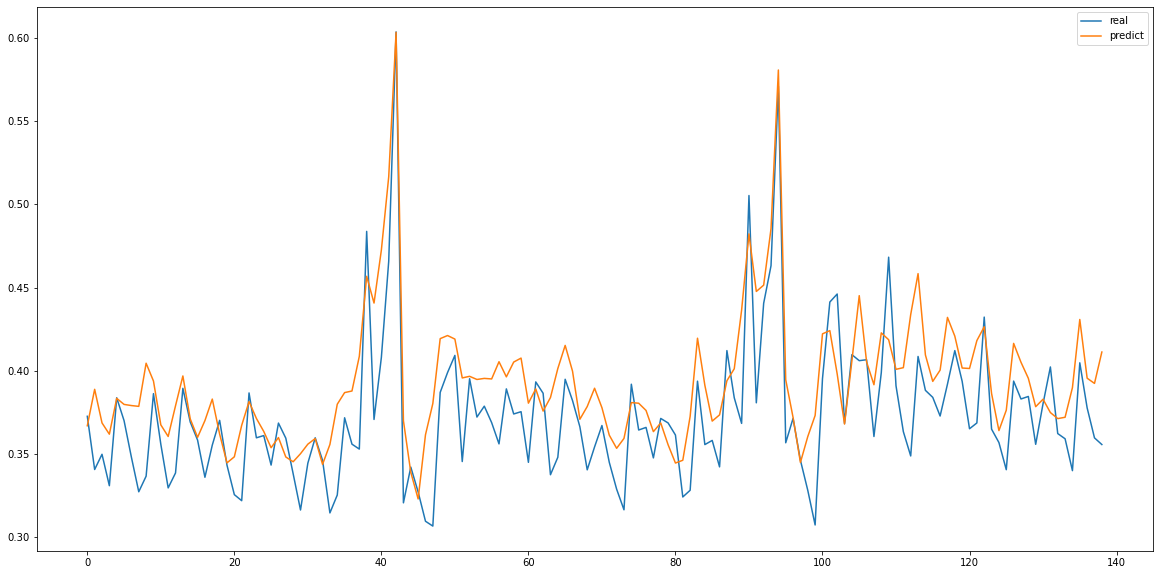

MAPE: 6.989576692064789%


In [53]:
test(model,test_one_dataset)